In [12]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import random
import datetime
import torch
import torch.nn as nn
import time
import flappy_bird_gymnasium
import gymnasium

device='cuda:2'
torch.cuda.set_device(2)
torch.backends.cudnn.benchmark = True
torch.cuda.set_per_process_memory_fraction(0.9)

In [13]:
UPDATE_MIN = 1            # 每次更新最少获取N条数据
RETAIN_COUNT = 20_000        # 数据池中最多保留的数据数量
TRAINING_COUNT = 1          # 每次更新数据后训练的次数
BATCH_SIZE = 1024            # 每次训练的批量大小
EPOCH = 20_0000              # 总训练轮数
LOAD_MODEL = 'model/model_final.ckpt'           # 读取保存的模型参数
# LOAD_MODEL = None           # 读取保存的模型参数

TEST_EPOCH = 100            # 测试轮数

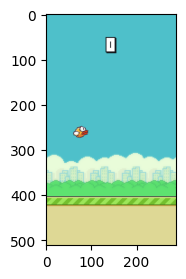

In [14]:
#定义环境
class FlappyBird(gym.Wrapper):

    def __init__(self):
        env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array")
        super().__init__(env)
        self.env = env

    def reset(self):
        state,_ = self.env.reset()
        return state

    def step(self, action):
        observation, reward, over, _, info = self.env.step(action)
        state = list(observation)
        if observation[9]<0:
            over = True
            reward = -100

        if reward == 0.1:
            reward = 0.01
        elif reward == 1.0:
            reward = 10
        elif over:
            reward = -100
        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()

    def close(self):
        if self.log != None:
            self.log.close()


env = FlappyBird()

env.reset()

env.show()
# state.shape=[210, 160, 3]

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(in_features=12, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=12),
            nn.ReLU(),
        )
        self.fc_action = torch.nn.Linear(12, 2)
        self.fc_state = torch.nn.Linear(12, 1)
        
    def forward(self, state):
        state = self.fc(state)

        #评估state的价值
        value_state = self.fc_state(state)

        #每个state下每个action的价值
        value_action = self.fc_action(state)

        #综合以上两者计算最终的价值,action去均值是为了数值稳定
        return value_state + value_action - value_action.mean(dim=-1,
                                                              keepdim=True)

In [16]:
#定义模型,评估状态下每个动作的价值
model = Model().to(device)

#延迟更新的模型,用于计算target
model_delay = Model().to(device)

#复制参数
if LOAD_MODEL != None:
    print(f'load weight {LOAD_MODEL}')
    model = torch.load(LOAD_MODEL).to(device)
model_delay.load_state_dict(model.state_dict())

load weight model3/model3_2023-09-30_01:02.txt_168.28.ckpt


<All keys matched successfully>

In [17]:
#玩一局游戏并记录数据
def play(show=False,explore=0.1):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(-1,12).to(device)).argmax().item()
        if random.random() < explore:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward
        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum

In [18]:
import numpy as np
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self,explore=0.1):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        s = 0
        i = 0
        while len(self.pool) - old_len < UPDATE_MIN:
            d,r = play(False,explore)[0]
            self.pool.extend(d)
            s += s
            i += 1

        #只保留最新的N条数据
        self.pool = self.pool[-RETAIN_COUNT:]
        return s/i

    #获取一批数据样本
    def sample(self,count=64):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 12).to(device)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1).to(device)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1).to(device)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 12).to(device)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1).to(device)

        return state, action, reward, next_state, over
    
    def read(self,path:str):
        with open(path,'r') as f:
            for line in f.readlines():
                line = line[1:-2].split(',')
                state = list(map(lambda x:float(x),line[0:12]))
                action = int(line[12])
                reward = float(line[13]) 
                next_state = list(map(lambda x:float(x),line[14:26]))
                over = bool(line[26])
                self.pool.append((state, action, reward, next_state, over))
    
    def write(self,path:str):
        with open(path,'w') as f:
            for data in self.pool:
                d = []
                for record in data:
                    if isinstance(record,np.ndarray | list)  :
                        d.extend(record)
                    else:
                        d.append(record)
                f.write(str(d)+'\n')

In [19]:
#训练
def train():
    pool = Pool()
    while len(pool)<RETAIN_COUNT/2:
        pool.update(0)
    
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()

    data_save_path = 'data2.txt'
    weight_save_dir = 'model'
    open(data_save_path,'w').close()
    s = 0
    for epoch in range(EPOCH):
        explore = 0.5*(1-epoch/EPOCH)
        sum = pool.update(explore)

        #每次更新数据后,训练N次
        for i in range(TRAINING_COUNT):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample(BATCH_SIZE)

            #计算value
            value = model(state).gather(dim=1, index=action)

            #计算target
            with torch.no_grad():
                target = model_delay(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            target = target * 0.99 * (1 - over) + reward

            loss = loss_fn(value, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #复制参数
        if (epoch + 1) % 5 == 0:
            model_delay.load_state_dict(model.state_dict())

        if epoch % 100 == 0:
            print(f'{epoch}, {s/100:.2f}')
            with open(data_save_path,'a') as f:
                time = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
                f.write(f'{epoch:06} {s/100:.2f} {explore:.2f} {time}\n')
            if epoch % 1000 == 0:
                filename = datetime.datetime.now().strftime('model_%Y-%m-%d_%R.txt')
                torch.save(model, f'{weight_save_dir}/{filename}_{s/100:.2f}.ckpt')
            s = 0

def test():
    class File(object):
        def __init__(self, path, clear=False):
            self.path = path
            if clear:
                open(path, 'w').close()

        def append(self, str: str, end='\n'):
            with open(self.path, 'a') as f:
                f.write(f'{str}{end}')
    data_save_path = 'test_2.txt'
    f = File(data_save_path, True)
    for i in range(TEST_EPOCH):
        r = play(False, 0)[-1]
        f.append(f'{i} {r}')
        print(f'{i} {r}')

In [23]:
test()

0 -99.0
1 -98.9
2 -99.0
3 -98.91
4 -98.91
5 -88.85
6 -99.0
7 -98.92999999999999
8 -98.98
9 -99.0
10 -98.97
11 -98.98
12 -88.89
13 -98.92999999999999
14 -99.0
15 -99.0
16 -88.9
17 -88.88
18 -88.89
19 -98.97
20 -98.96
21 -98.96
22 -98.95
23 -98.9
24 -88.60000000000001
25 -88.88
26 -99.0
27 -88.84
28 -98.95
29 -98.92999999999999
30 -98.99
31 -88.88
32 -98.9
33 -98.91
34 -98.92999999999999
35 -98.92999999999999
36 -98.98
37 -98.99
38 -88.89
39 -88.89
40 -98.92
41 -88.89
42 -99.0
43 -98.99
44 -98.96
45 -98.91
46 -98.98
47 -88.89
48 -98.96
49 -99.0
50 -98.98
51 -88.88
52 -99.0
53 -98.9
54 -98.95
55 -99.0
56 -88.87
57 -88.88
58 -98.91
59 -99.0
60 -98.91
61 -99.0
62 -98.99
63 -98.94
64 -98.92999999999999
65 -99.0
66 -99.0
67 -98.95
68 -88.89
69 -98.99
70 -98.97
71 -98.91
72 -88.89
73 -88.88
74 -98.96
75 -98.96
76 -88.89
77 -99.0
78 -88.88
79 -98.95
80 -99.0
81 -88.89
82 -98.91
83 -98.92999999999999
84 -98.92999999999999
85 -88.89
86 -98.91
87 -98.98
88 -88.89
89 -98.94
90 -99.0
91 -98.98
92 -8

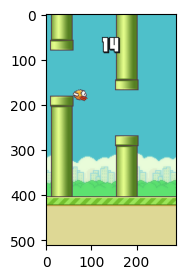

45.940000000000566

In [ ]:
play(True,0)[-1]